In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [ ]:
DEVICE = 'cpu'

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
# import warnings
# warnings.simplefilter("always")  # always show warnings!

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# dataset
from src.wf_datasets import DatasetOfWavefronts

In [15]:
from tqdm import tqdm

In [16]:
from datetime import datetime

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Convolutional Diffractive Network

This notebook is based on the article <span style="color:orange">"Optical Diffractive Convolutional Neural Networks
Implemented in an All-Optical Way"</span> [[1]](https://www.mdpi.com/1424-8220/23/12/5749).

> ... combining the 4f system as an optical convolutional layer and the diffractive networks

In [18]:
today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # date for a results folder name
today_date

'11-04-2025_00-38'

In [19]:
# Define all necessery variables for that notebook
VARIABLES = {
    # FILEPATHES
    'data_path': './data',  # folder which will be created (if not exists) to load/store Weizmann dataset
    'results_path': f'models/convolutional/conv_exp_{today_date}',  # filepath to save results!
    
    # GENERAL SETTINGS - SECTION 1 of the notebook
    'wavelength': 750 * 1e-6,  # working wavelength, in [m]
    'neuron_size': 0.5 * 750 * 1e-6,  # size of a pixel for DiffractiveLayers, in [m]
    'mesh_size': (200, 200),  # full size of a layer = numerical mesh
        # Comment: value from the article [1] - (200, 200)

    'use_apertures': False,  # if we need to add apertures before each Diffractie layer
        # Comment: value from the article [1] - unknown
    'aperture_size': (64, 64),  # size of each aperture = a detector square for classes zones
        # Comment: value from the article [1] - unknown
    
    # DATASET OF SUBSEQUENCES SETTINGS - SECTION 2 of the notebook
    'resize': (28, 28),  # size to resize pictures to add 0th padding then (up to the mesh size)
        # Comment: value from the article: the input image of 28 * 28 pixels size
    'modulation': 'amp',  # modulation type to make a wavefront from each picture mask (see 2.3.2.)
        # Comment: can be equal to `phase`, `amp` or `both`

    # NETWORK - SECTION 3 of the notebook
    'max_phase': 2 * torch.pi,  # maximal possible phase for each DiffractiveLayer
    'free_space_method': 'AS',  # propagation method
        # Comment: can be 'AS' or 'fresnel'
    'distance': 3 * 1e-2,  # distance between diffractive layers 

    # 4F-SYSTEM
    'focal_length': 3 * 1e-2,  # in [m]
    'lens_radius': torch.inf,
        # Comment: if a lens radius is equal to torch.inf - analytical lens!
    'learnable_kernel': False,

    # DIFFRACTIVE LAYERS
    'use_slm': False,  # use SLM (if True) or DiffractiveLayers (if False)
    'num_layers': 5,
    'init_phases': torch.pi,
    # value or a list of initial constant phases for DiffractiveLayers OR SLM
    # SLM settings - if 'use_slm' == True
        # Comment: a size of each SLM is equal to SimulationParameters!
    'slm_shapes': [(200, 200), (200, 200), (100, 100), (100, 100), (100, 100)],
        # list of size 'encoder_num_layers'
    'slm_levels': 256, 
        # value OR a list (len = 'encoder_num_layers') of numbers of levels for each SLM
    'slm_step_funcs': 'linear',  # value OR a list of step function names
        # Comment: available stp functions names - 'linear'

    # NETWORK LEARNING - SECTION 4 of the notebook
    'calculate_accuracies': True,  # will be always True for CrossEnthropyLoss! (see 3.1.4.)
        # Comment: MSE loss used!
    'DEVICE': DEVICE,  # if `cuda` - we will check if it is available (see first cells of Sec. 4)
    'train_batch_size': 64,  # batch sizes for training (see 4.1.1.)
    'val_batch_size': 64,
        # Comment: value from the article [1] - 64  # for both train and test?
    'adam_lr': 0.01,  # learning rate for Adam optimizer (see 4.1.2.)
        # Comment: value from the article [1] - 0.01
    'number_of_epochs': 20,  # number of epochs to train
        # Comment: value from the article [1] - 100-300 ?!
}

In [20]:
# functions for SLM step (look documentation of SLM)
SLM_STEPS = {
    'linear': lambda x: x,
}

In [21]:
RESULTS_FOLDER = VARIABLES['results_path']

# create a directory to store results
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [22]:
RESULTS_FOLDER

'models/convolutional/conv_exp_11-04-2025_00-38'

In [23]:
# save experiment conditions (VARIABLES dictionary)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

# 1. Simulation parameters

Since in [[1]](https://www.mdpi.com/1424-8220/23/12/5749) there are no details, we took physical parameters from another article [[2]](https://ieeexplore.ieee.org/abstract/document/8732486), which we used in some previous notebooks.

In [24]:
working_wavelength = VARIABLES['wavelength']  # [m] - like for MNIST

c_const = 299_792_458  # [m / s]
working_frequency = c_const / working_wavelength # [Hz]

In [25]:
print(f'lambda    = {working_wavelength * 1e3:.3f} mm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 0.750 mm
frequency = 0.400 THz


In [26]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']  # [m] - like for MNIST
print(f'neuron size = {neuron_size * 1e3:.3f} mm')

neuron size = 0.375 mm


In [27]:
APERTURES = VARIABLES['use_apertures']  # add apertures BEFORE each diffractive layer or not

In [28]:
LAYER_SIZE = VARIABLES['mesh_size']  # mesh size
DETECTOR_SIZE = VARIABLES['aperture_size']

In [29]:
# number of neurons in simulation
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 200 x 200 = 40000


In [30]:
# physical size of each layer
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 75.000 x 75.000


In [31]:
X_LAYER_SIZE_M = x_layer_size_m
Y_LAYER_SIZE_M = y_layer_size_m

In [32]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [33]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = VARIABLES['data_path']  # folder to store data

NUM_CLASSES = 10

### 2.1.1. Load Train and Test datasets of images

In [34]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [35]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [36]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Create Train and Test datasets of wavefronts

> the input image of $28 \times 28$ pixels size was expanded to $200 \times 200$ with zero padding

In [37]:
# select modulation type
MODULATION_TYPE = VARIABLES['modulation']  # using ONLY amplitude to encode each picture in a Wavefront!
RESIZE_SHAPE = VARIABLES['resize']  # size to resize pictures to add 0th padding then (up to the mesh size)

#### Transformations

In [38]:
resize_y = RESIZE_SHAPE[0]
resize_x = RESIZE_SHAPE[1]  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [39]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- selected modulation type here!!!
  ]  
)

#### Detector mask

In [40]:
import src.detector_segmentation as detector_segmentation

In [41]:
number_of_classes = NUM_CLASSES

In [42]:
detector_segment_size = 6.4 * working_wavelength

In [43]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [44]:
y_boundary_nodes = y_segment_nodes * 12
x_boundary_nodes = x_segment_nodes * 12

In [45]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)

To visualize detector zones (for further use)

In [46]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [47]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 1 #0.5
    
    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

Visualize mask

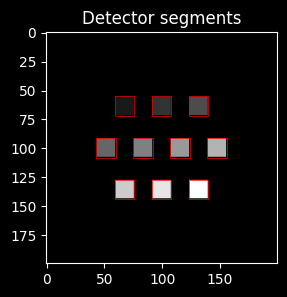

In [48]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

#### Train and Test datasets

In [49]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [50]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [51]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


#### Examples

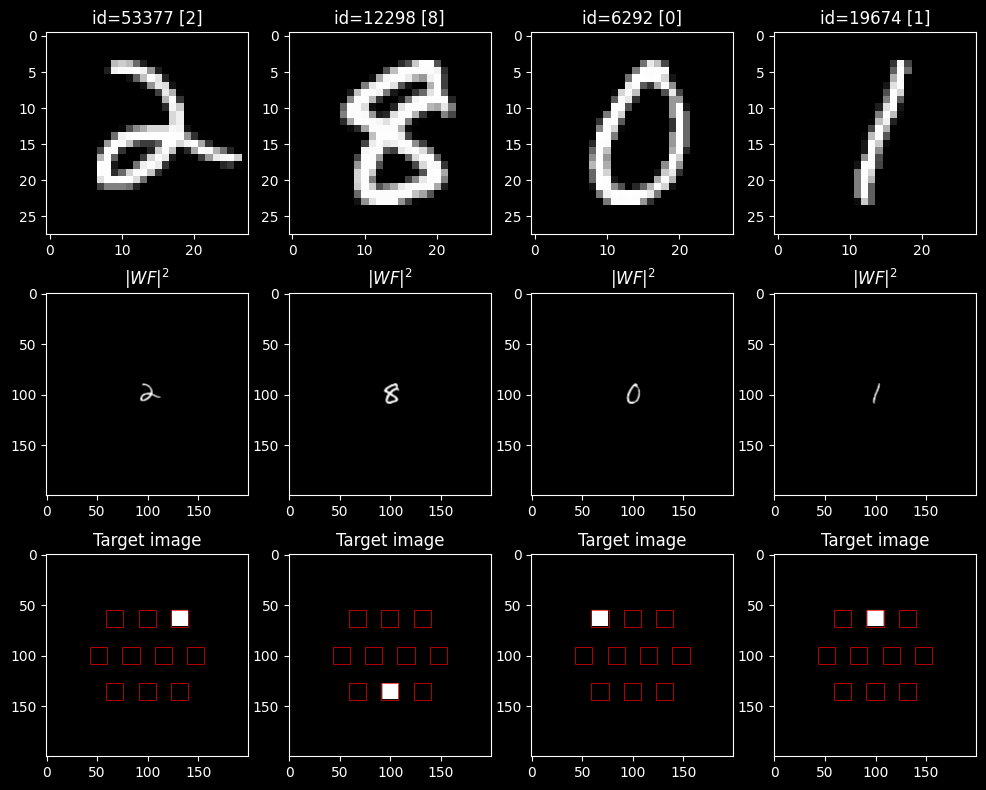

In [52]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, target_image = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    axs[2][ind_ex].set_title(f'Target image')
    axs[2][ind_ex].imshow(
        target_image, cmap='gray',
        vmin=0, vmax= 1
    )
    
    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[2][ind_ex].add_patch(zone)

plt.show()

# 3. Diffractive Network with Convolutional Layer

In [53]:
FS_METHOD = VARIABLES['free_space_method']
FS_DISTANCE = VARIABLES['distance']  # [m] - distance between difractive layers

MAX_PHASE = VARIABLES['max_phase']

## 3.1. Optical Convolutional Layer

See Figure 2 in [[1]](https://www.mdpi.com/1424-8220/23/12/5749)!

In [54]:
FOCAL_LENGTH = VARIABLES['focal_length']
LENS_R = VARIABLES['lens_radius']

LEARN_CONV = VARIABLES['learnable_kernel']

### 3.1.1. Function to return 4f system

In [55]:
def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )

In [56]:
def get_4f_convolutional_layer(
    sim_params, 
    focal_length,  # in [m]
    lens_radius,  # in [m]
    convolutional_mask,  # mask from 0 to max_phase
    learnable_mask = False,  # if a convolutional mask is learnable
    max_phase=2 * torch.pi,
    freespace_method='AS',
):
    """
    Returns a list of elements for a 4f system with a Diffractive layer in a Fourier plane.
    """
    if learnable_mask:
        diff_layer = elements.DiffractiveLayer(
            simulation_parameters=sim_params,
            mask=ConstrainedParameter(
                convolutional_mask,
                min_value=0,
                max_value=max_phase
            ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
        )
    else:
        diff_layer = elements.DiffractiveLayer(
            simulation_parameters=sim_params,
            mask=convolutional_mask,  # mask is not changing during the training!
        )

    return [
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        elements.ThinLens(sim_params, focal_length, lens_radius),
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        diff_layer,  # DiffractiveLayer in a Fourier plane!
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        elements.ThinLens(sim_params, focal_length, lens_radius),
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
    ]

### 3.1.2. Mask for a `DiffractiveLayer` placed in a Fourier plane

Citations from [[1]](https://www.mdpi.com/1424-8220/23/12/5749)

> In the convolution layer, $16$ convolution kernels were discretized into
a $4 \times 4$ array and tiled into a $200 \times 200$ size planar space, as shown in Figure 6.

#### Functions to generate kernels

In [57]:
from kernels.kernels import *

In [58]:
# Generate All 16 Kernels

def generate_16_kernels(size=9):
    k3 = predefined_3x3_kernels()

    kernels = [
        gaussian_kernel(size, sigma=1.0),
        gaussian_kernel(size, sigma=2.0),
        laplacian_of_gaussian(size, sigma=1.0),
        gabor_kernel(size, theta=0),
        gabor_kernel(size, theta=math.pi / 4),
        gabor_kernel(size, theta=math.pi / 2),
        gabor_kernel(size, theta=3 * math.pi / 4),
        upscale_kernel(k3['sobel_x'], size),
        upscale_kernel(k3['sobel_y'], size),
        upscale_kernel(k3['prewitt_x'], size),
        upscale_kernel(k3['prewitt_y'], size),
        upscale_kernel(k3['emboss'], size),
        identity_kernel(size),
        center_surround_edge_kernel(size),
        gabor_kernel(size, theta=math.pi / 8),
        gabor_kernel(size, theta=5 * math.pi / 8)
    ]

    return torch.stack(kernels)  # shape: (16, 9, 9)

In [59]:
# TODO: Randomly mix kernels before arrangement!
def embed_equally_spaced_kernels(canvas_size=200, grid_size=4, kernel_size=9):
    
    spacing = (canvas_size - (grid_size * kernel_size)) // (grid_size + 1)  # == 32
    kernels = generate_16_kernels()  # (16, 9, 9)
    canvas = torch.zeros((canvas_size, canvas_size))

    idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            y = spacing + i * (kernel_size + spacing)
            x = spacing + j * (kernel_size + spacing)
            canvas[y:y + kernel_size, x:x + kernel_size] = kernels[idx]
            idx += 1

    return canvas

#### Convolutional layer with generated kernels

In [60]:
KERNELS_MASK = embed_equally_spaced_kernels() * MAX_PHASE

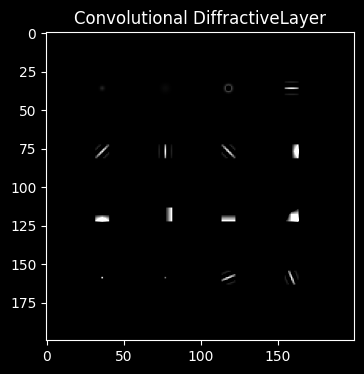

In [61]:
fig, ax0 = plt.subplots(1, 1, figsize=(4, 4))

ax0.set_title(f'Convolutional DiffractiveLayer')
ax0.imshow(KERNELS_MASK, cmap='grey', vmin=0, vmax=MAX_PHASE)

plt.show()

### 3.1.3. Convolution Layer (4f system)

In [62]:
CONV_LAYER = get_4f_convolutional_layer(
    SIM_PARAMS, 
    FOCAL_LENGTH,  # in [m]
    LENS_R,  # in [m]
    KERNELS_MASK,  # mask from 0 to max_phase
    learnable_mask=LEARN_CONV,  # if a convolutional mask is learnable
    max_phase=MAX_PHASE,
    freespace_method=FS_METHOD,
)

## 3.2. Optical Network after a Convolutional Layer

In [63]:
USE_SLM = VARIABLES['use_slm']
NUM_LAYERS = VARIABLES['num_layers']  # number of diffractive layers

In [64]:
if isinstance(VARIABLES['init_phases'], list):
    INIT_PHASES = VARIABLES['init_phases']
else:
    INIT_PHASES = [VARIABLES['init_phases'] for _ in range(NUM_LAYERS)]


assert len(INIT_PHASES) == NUM_LAYERS

In [65]:
if USE_SLM:
    SLM_VARIABLES = {}
    
    for key in ['slm_shapes', 'slm_levels', 'slm_step_funcs']:
        if key != 'slm_step_funcs':
            
            if isinstance(VARIABLES[key], list):
                SLM_VARIABLES[key] = VARIABLES[key]
            else:  # all SLM's have the same parameter
                SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_LAYERS)]
                
        else:  # for step functions!
            
            if isinstance(VARIABLES[key], list):
                SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # all SLM's have the same parameter
                SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_LAYERS)]
    
        assert len(SLM_VARIABLES[key]) == NUM_LAYERS

### 3.2.1. Functions to get new elements

In [66]:
# functions that return single elements for further architecture
def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!


# CHANGE ACCORDING TO THE DOCUMENTATION OF SLM!
def get_const_slm_layer(
    sim_params: SimulationParameters,
    mask_shape, 
    phase_value,
    num_levels, 
    step_func,
    height_m=Y_LAYER_SIZE_M,
    width_m=X_LAYER_SIZE_M,
    max_phase=2 * torch.pi
):
    """
    Returns SpatialLightModulator with a constant phase mask.
    """
    y_nodes, x_nodes = mask_shape
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * phase_value
    
    return elements.SpatialLightModulator(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
        height=height_m,
        width=width_m,
        # location=(0., 0.),  # by default
        number_of_levels=num_levels,
        step_function=step_func,
        # mode='nearest',  # by default it is 'nearest'
    )  # ATTENTION TO DOCUMENTATION!

### 3.2.2. Elements list
Function to get a list of elements to reproduce an architecture:

In [67]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_distance,
    freespace_method,
    apertures=False,
    aperture_size=(100, 100),
):
    """
    Composes a list of elements for an encoder (with no Detector).
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_distance : float,
        A distance between phase layers in [m].
    freespace_method : str
        Propagation method for free spaces in a setup.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of square apertures.

    mode : str
        Takes values: 'encoder' or 'decoder'.
        
    Returns
    -------
    elements_list : list(Element)
        List of Elements for an encoder/decoder.
    """
    elements_list = []  # list of elements

    use_slm = USE_SLM
    init_phases = INIT_PHASES
    if use_slm:
        slm_masks_shape = SLM_VARIABLES['encoder_slm_shapes']
        slm_levels = SLM_VARIABLES['encoder_slm_levels']
        slm_funcs = SLM_VARIABLES['encoder_slm_step_funcs']
    
    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # padding transform to match aperture size with simulation parameters     
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # first FreeSpace layer before first DiffractiveLayer
    # after 4f-system already have a FreeSpace

    # compose the architecture
    for ind_layer in range(num_layers):

        # add strickt square Aperture
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )
            
        # ------------------------------------------------------------PHASE LAYER
        if use_slm:  # add a phase layer (SLM or DiffractiveLayer)
            # add SLM (learnable phase mask)
            elements_list.append(
                get_const_slm_layer(
                    simulation_parameters,
                    mask_shape=slm_masks_shape[ind_layer], 
                    phase_value=init_phases[ind_layer],
                    num_levels=slm_levels[ind_layer], 
                    step_func=slm_funcs[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        else:
            # add DiffractiveLayer (learnable phase mask)
            elements_list.append(
                get_const_phase_layer(
                    simulation_parameters,
                    value=init_phases[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        # -----------------------------------------------------------------------
        
        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                freespace_distance,  # in [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------    
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

## 3.3. Model with a Convolutional Layer (4f System)

### 3.3.1. Model Class

In [68]:
class ConvolutionalSystem(nn.Module):
    """
    A simple convolutional network with a 4f system as an optical convolutional layer.
    """

    def __init__(
        self,
        sim_params: SimulationParameters,
        conv_layer_list: list,
        num_layers: int,
        fs_distance: float,
        fs_method: str = 'AS',
        device: str | torch.device = torch.get_default_device(),
    ):
        """
        Parameters
        ----------
        sim_params : SimulationParameters
            Simulation parameters for the task.
        conv_layer_list : list
            List of Elements for a Convolutional layer (4f system).
        num_layers : int
            Number of DiffractiveLayer's after 4f-system.
        fs_distance : float,
            A distance between phase layers in [m].
        fs_method : str
            Propagation method for free spaces in a setup.
        elements_list : list
            List of elements to compose a network after a Convolutional Layer.
        """
        super().__init__()

        self.sim_params = sim_params

        self.h, self.w = self.sim_params.axes_size(
            axs=('H', 'W')
        )  # height and width for a wavefronts
        
        self.__device = device
        self.fs_method = fs_method

        # CONVOLUTIONAL LAYER
        self.conv_layer_list = conv_layer_list
        self.conv_layer = nn.Sequential(*conv_layer_list).to(self.__device)
        
        # NETWORK
        elements_list = get_elements_list(
            num_layers,
            self.sim_params,
            fs_distance,
            fs_method,
            apertures=VARIABLES['use_apertures'],
            aperture_size=VARIABLES['aperture_size'],
        )  # Detector is here!

        # self.encoder_elements = encoder_elements_list
        self.net = nn.Sequential(*elements_list).to(self.__device)

    def stepwise_propagation(self, input_wavefront: Wavefront, mode: str='encode'):
        """
        Function that consistently applies forward method of each element of 
        Convolution Layer or the Network after Convolution
        to an `input_wavefront`.

        Parameters
        ----------
        input_wavefront : torch.Tensor
            A wavefront that enters the optical network.
        mode : str
            Specify a mode 'convolution' or 'after convolution'.

        Returns
        -------
        str
            A string that represents a scheme of a propagation through a setup.
        list(torch.Tensor)
            A list of an input wavefront evolution during a propagation through a setup.
        """
        this_wavefront = input_wavefront
        # list of wavefronts while propagation of an initial wavefront through the system
        steps_wavefront = [this_wavefront]  # input wavefront is a zeroth step

        optical_scheme = ''  # string that represents a linear optical setup (schematic)

        if mode == 'convolution':
            net = self.conv_layer
        if mode == 'after convolution':
            net = self.net
            
        net.eval()
        for ind_element, element in enumerate(net):
            # for visualization in a console
            element_name = type(element).__name__
            optical_scheme += f'-({ind_element})-> [{ind_element + 1}. {element_name}] '

            if ind_element == len(net) - 1:
                optical_scheme += f'-({ind_element + 1})->'
    
            # element forward
            with torch.no_grad():
                this_wavefront = element.forward(this_wavefront)
            
            steps_wavefront.append(this_wavefront)  # add a wavefront to list of steps

        return optical_scheme, steps_wavefront

    def forward(self, wavefront_in):
        """
        Parameters
        ----------
        wavefront_in: Wavefront('bs', 'H', 'W')

        Returns
        -------
        detector_image : torch.Tensor
            Image on a Detector.
        """
        if len(wavefront_in.shape) > 2:  # if a batch is an input
            batch_flag = True
            bs = wavefront_in.shape[0]
        else:
            batch_flag = False

        # convolutional layer
        wavefront_after_convolution = self.conv_layer(wavefront_in)
        # other layers
        detector_image = self.net(wavefront_after_convolution)
        
        return detector_image

### 3.3.2. Empty model

In [69]:
def get_net():
    return ConvolutionalSystem(
        SIM_PARAMS,
        CONV_LAYER,
        NUM_LAYERS,
        FS_DISTANCE,
        FS_METHOD,
    )

## 3.4. Detector processor (to calculate accuracies only)

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [70]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies'] 
# if False, accuracies will not be calculated!

In [71]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=NUM_CLASSES,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

### 3.1.4 Detector processor (to calculate accuracies only)

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [72]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies']  # if False, accuracies will not be calculated!

In [73]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=NUM_CLASSES,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 4. Training of the network

In [74]:
DEVICE = VARIABLES['DEVICE']  # 'mps' is not support a CrossEntropyLoss

In [75]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> The batch size set for the training process was $64$.

In [76]:
train_bs = VARIABLES['train_batch_size']  # a batch size for training set
val_bs = VARIABLES['val_batch_size']

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [77]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [78]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

In [79]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=val_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

In [80]:
LR = VARIABLES['adam_lr']

In [81]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [82]:
LOSS = 'MSE'

In [83]:
if LOSS == 'MSE':
    loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
    loss_func_name = 'MSE'

### 4.1.3. Training and evaluation loops

In [84]:
def onn_train_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR needed for accuracies only!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Function to train `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0
    
    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()

        # forward of an optical network
        detector_output = optical_net(batch_wavefronts)
        
        # calculate loss for a batch
        loss = loss_func(detector_output, batch_targets)
        
        loss.backward()
        optimizer.step()

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_output)
            
            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()
            
            correct_preds += batch_correct_preds    
            size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.
    
    return batches_losses, batches_accuracies, epoch_accuracy

In [85]:
def onn_validate_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # calculate loss for a batch
            loss = loss_func(detector_outputs, batch_targets)

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)
                
            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()
            
            correct_preds += batch_correct_preds    
            size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.
    
    return batches_losses, batches_accuracies, epoch_accuracy

## 4.2. Training of the optical network

### 4.2.1. Before training

> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

#### Metrics for Test dataset

In [86]:
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

untrained_net = get_net().to(DEVICE)
if detector_processor:
    detector_processor = detector_processor.to(DEVICE)

In [87]:
test_losses_0, _, test_accuracy_0 = onn_validate_mse(
    untrained_net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|██████████████████████████████████████████| 157/157 [00:38<00:00,  4.10it/s]

Results before training on TEST set:
	MSE : 0.006371
	Accuracy : 9.9 %


### 4.2.2. Training

In [88]:
n_epochs = VARIABLES['number_of_epochs']
print_each = 2  # print each n'th epoch info

In [89]:
scheduler = None  # sheduler for a lr tuning during training 

In [91]:
# Recreate a system to restart training!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
net_to_train = get_net().to(DEVICE)

# Linc optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(net_to_train)

In [92]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_mse(
        net_to_train,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_mse(
        net_to_train,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|███████████████████████████████████████████████| 860/860 [08:08<00:00,  1.76it/s]


Training results
	MSE : 0.005861
	Accuracy : 51.9 %
	------------   488.81 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:28<00:00,  2.75it/s]


Validation results
	MSE : 0.005754
	Accuracy : 64.0 %
	------------   28.74 s
Epoch #2: 

train: 100%|███████████████████████████████████████████████| 860/860 [08:58<00:00,  1.60it/s]


Training results
	MSE : 0.005718
	Accuracy : 64.7 %
	------------   538.35 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:30<00:00,  2.63it/s]


Validation results
	MSE : 0.005709
	Accuracy : 63.8 %
	------------   30.09 s
Epoch #4: 

train: 100%|███████████████████████████████████████████████| 860/860 [10:12<00:00,  1.41it/s]


Training results
	MSE : 0.005675
	Accuracy : 67.2 %
	------------   612.07 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:30<00:00,  2.61it/s]


Validation results
	MSE : 0.005678
	Accuracy : 67.5 %
	------------   30.33 s
Epoch #6: 

train: 100%|███████████████████████████████████████████████| 860/860 [09:11<00:00,  1.56it/s]


Training results
	MSE : 0.005661
	Accuracy : 67.9 %
	------------   551.55 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:30<00:00,  2.57it/s]


Validation results
	MSE : 0.005667
	Accuracy : 68.6 %
	------------   30.70 s
Epoch #8: 

train: 100%|███████████████████████████████████████████████| 860/860 [10:45<00:00,  1.33it/s]


Training results
	MSE : 0.005653
	Accuracy : 68.3 %
	------------   645.20 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:32<00:00,  2.41it/s]


Validation results
	MSE : 0.005660
	Accuracy : 67.1 %
	------------   32.82 s
Epoch #10: 

train: 100%|███████████████████████████████████████████████| 860/860 [11:06<00:00,  1.29it/s]


Training results
	MSE : 0.005648
	Accuracy : 68.6 %
	------------   666.04 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:31<00:00,  2.53it/s]


Validation results
	MSE : 0.005655
	Accuracy : 68.3 %
	------------   31.26 s
Epoch #12: 

train: 100%|███████████████████████████████████████████████| 860/860 [09:17<00:00,  1.54it/s]


Training results
	MSE : 0.005645
	Accuracy : 68.8 %
	------------   557.04 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:30<00:00,  2.61it/s]


Validation results
	MSE : 0.005652
	Accuracy : 68.8 %
	------------   30.32 s
Epoch #14: 

train: 100%|███████████████████████████████████████████████| 860/860 [09:12<00:00,  1.56it/s]


Training results
	MSE : 0.005643
	Accuracy : 68.9 %
	------------   552.11 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:30<00:00,  2.61it/s]


Validation results
	MSE : 0.005651
	Accuracy : 68.0 %
	------------   30.30 s
Epoch #16: 

train: 100%|███████████████████████████████████████████████| 860/860 [09:34<00:00,  1.50it/s]


Training results
	MSE : 0.005641
	Accuracy : 68.9 %
	------------   574.58 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:31<00:00,  2.53it/s]


Validation results
	MSE : 0.005650
	Accuracy : 68.5 %
	------------   31.20 s
Epoch #18: 

train: 100%|███████████████████████████████████████████████| 860/860 [09:37<00:00,  1.49it/s]


Training results
	MSE : 0.005640
	Accuracy : 68.9 %
	------------   577.47 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:31<00:00,  2.50it/s]


Validation results
	MSE : 0.005649
	Accuracy : 68.9 %
	------------   31.63 s
Epoch #20: 

train: 100%|███████████████████████████████████████████████| 860/860 [10:10<00:00,  1.41it/s]


Training results
	MSE : 0.005639
	Accuracy : 69.1 %
	------------   610.99 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:31<00:00,  2.54it/s]

Validation results
	MSE : 0.005648
	Accuracy : 68.6 %
	------------   31.16 s


#### Learning curves (MSELoss and Accuracy)

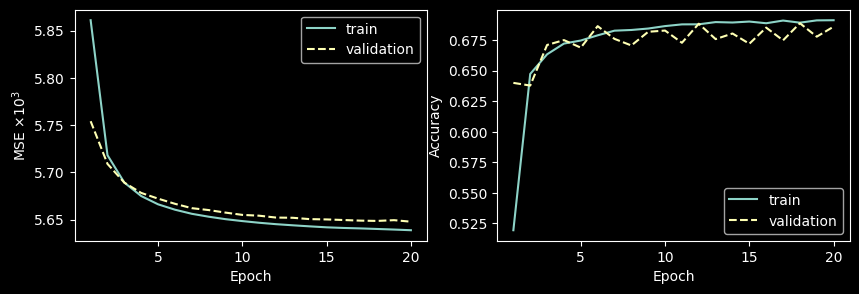

In [93]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name + r' $\times 10^3$')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

#### Trained masks (encoder)

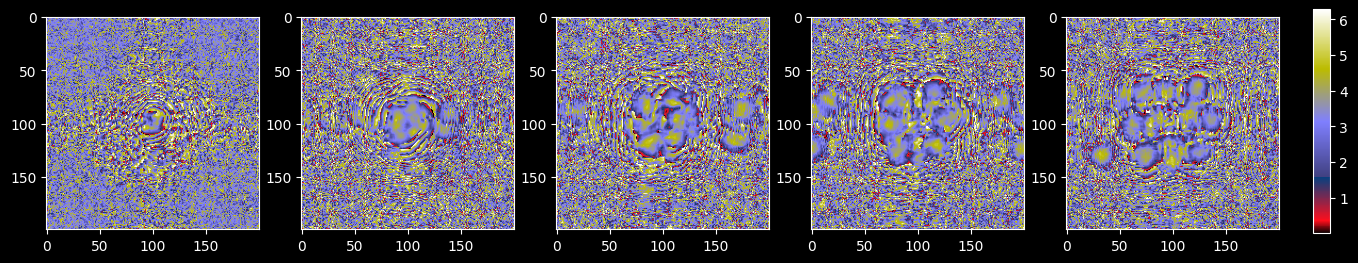

In [95]:
n_cols = NUM_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

net_to_plot = net_to_train.net

for ind_layer, layer in enumerate(net_to_plot):
    if isinstance(layer, elements.DiffractiveLayer) or isinstance(layer, elements.SpatialLightModulator):  
        # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        # ax_this.set_title(titles[ind_module])

        trained_mask = layer.mask.detach()
        
        phase_mask_this = ax_this.imshow(         
            trained_mask, cmap=cmap,
            # vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

        if APERTURES:  # select only a part within apertures!
            x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
            y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
            ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

#### Saving results

In [78]:
# array with all losses
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

In [79]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/conv_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Saving model weights and learning curves

In [80]:
# saving model
torch.save(net_to_train.state_dict(), model_filepath)

In [81]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)